In [28]:
import cv2
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import trimesh
def normalize_disparity_map(disparity_map):
    # Normalize disparity map for visualization
    # disparity should be larger than zero
    return np.maximum(disparity_map, 0.0) / disparity_map.max()
    
def visualize_disparity_map(disparity_map, gt_map, m, i):
    # Normalize disparity map
    disparity_map = normalize_disparity_map(disparity_map)
    gt_map = normalize_disparity_map(gt_map)
    # Visualize
    concat_map = np.concatenate([disparity_map, gt_map], axis=1)
    plt.imshow(concat_map, 'gray')
    plt.title(m+'_'+str(2*i))
    plt.savefig('./result2/'+m+'/'+m+'_'+str(2*i)+'.png',bbox_inches='tight')
    plt.show()


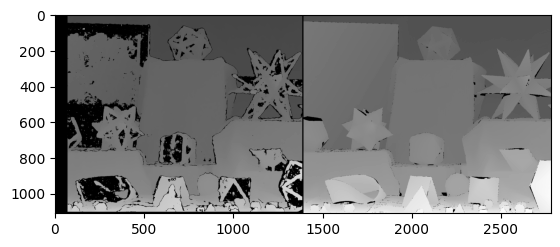

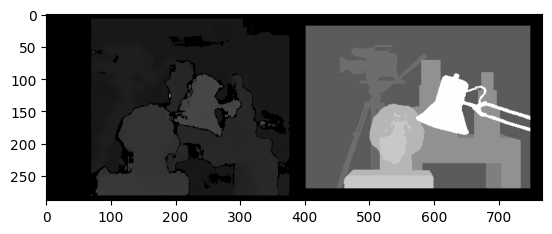

In [4]:
# Read images
moebius_image1 = cv2.imread("data/moebius1.png")
moebius_image1_gray = cv2.cvtColor(moebius_image1, cv2.COLOR_BGR2GRAY)
moebius_image2 = cv2.imread("data/moebius2.png")
moebius_image2_gray = cv2.cvtColor(moebius_image2, cv2.COLOR_BGR2GRAY)
moebius_gt = cv2.imread("data/moebius_gt.png", cv2.IMREAD_GRAYSCALE)

tsukuba_image1 = cv2.imread("data/tsukuba1.jpg")
tsukuba_image1_gray = cv2.cvtColor(tsukuba_image1, cv2.COLOR_BGR2GRAY)
tsukuba_image2 = cv2.imread("data/tsukuba2.jpg")
tsukuba_image2_gray = cv2.cvtColor(tsukuba_image2, cv2.COLOR_BGR2GRAY)
tsukuba_gt = cv2.imread("data/tsukuba_gt.jpg", cv2.IMREAD_GRAYSCALE)


# Task 0: Visualize cv2 Results
stereo = cv2.StereoBM.create(numDisparities=64, blockSize=15)
moebius_disparity_cv2 = stereo.compute(moebius_image1_gray, moebius_image2_gray)
visualize_disparity_map(moebius_disparity_cv2, moebius_gt)
tsukuba_disparity_cv2 = stereo.compute(tsukuba_image1_gray, tsukuba_image2_gray)
visualize_disparity_map(tsukuba_disparity_cv2, tsukuba_gt)

In [5]:
def compute_disparity_map_simple(ref_image, sec_image, window_size, disparity_range, matching_function):
    # 1. Simple Stereo System: image planes are parallel to each other
    # 2. For each row, scan all pixels in that row
    # 3. Generate a window for each pixel
    # 4. Search a disparity(d) in (min_disparity, max_disparity)
    # 5. Select the best disparity that minimize window difference between (row, col) and (row, col - d)
    
    rows, cols = ref_image.shape
    disparity_map = np.zeros_like(ref_image, dtype=np.float32)

    for row in range(window_size, rows - window_size):
        for col in range(window_size, cols - window_size):
            ref_window = ref_image[row - window_size:row + window_size + 1, col - window_size:col + window_size + 1]
            best_disparity = 0
            min_cost = float('inf')
            for d in range(disparity_range[0], disparity_range[1] + 1):
                sec_col = col - d
                if sec_col < window_size or sec_col >= cols - window_size:
                    continue
                sec_window = sec_image[row - window_size:row + window_size + 1, sec_col - window_size:sec_col + window_size + 1]
                if matching_function == 'SSD':
                    cost = np.sum((ref_window - sec_window) ** 2)
                elif matching_function == 'SAD':
                    cost = np.sum(np.abs(ref_window - sec_window))
                elif matching_function == 'normalized_correlation':
                    ref_normal = ref_window - np.mean(ref_window)
                    sec_normal = sec_window - np.mean(sec_window)
                    cost = -np.sum(ref_normal * sec_normal) / (np.sqrt(np.sum(ref_normal ** 2)) * np.sqrt(np.sum(sec_normal ** 2)) + 1e-6)
                if cost < min_cost:
                    min_cost = cost
                    best_disparity = d
            disparity_map[row, col] = best_disparity
    return disparity_map

In [27]:
def simple_disparity(ref_image, second_image, gt_map):
    # 1. Change window size, disparity range and matching functions
    # 2. Report the disparity maps and running time
    
    window_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]  # Try different window sizes
    disparity_range = (0, 64)  # Determine appropriate disparity range
    matching_functions = ['SSD', 'normalized_correlation']  # Try different matching functions
    # Generate disparity maps for different settings
    for window_size in window_sizes:
        for matching_function in matching_functions:
            disparity_map = compute_disparity_map_simple(ref_image, second_image, window_size, disparity_range, matching_function)
            visualize_disparity_map(disparity_map, gt_map, matching_function, window_size)

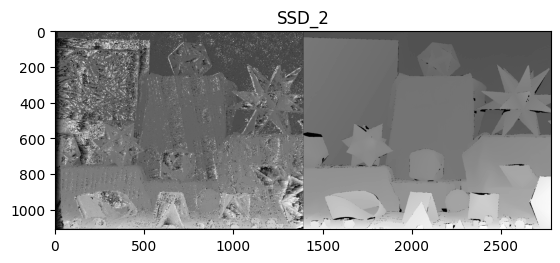

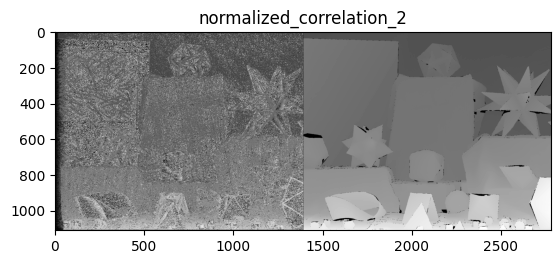

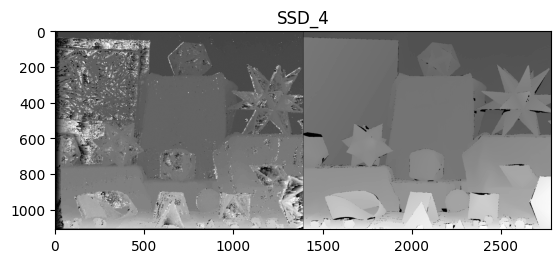

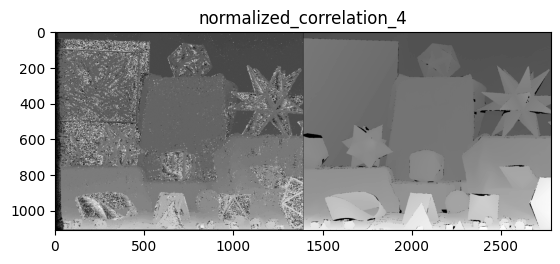

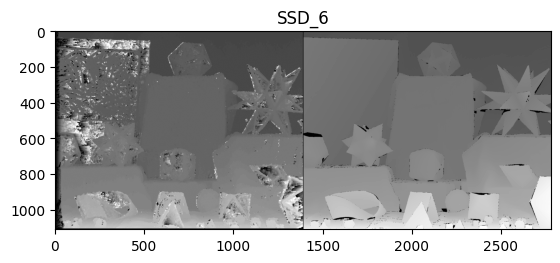

In [29]:
# This may run for a long time! 
simple_disparity(moebius_image1_gray, moebius_image2_gray, moebius_gt)

In [ ]:
# Task 1: Simple Disparity Algorithm
simple_disparity(tsukuba_image1_gray, tsukuba_image2_gray, tsukuba_gt)

In [23]:
def visualize_pointcloud(ref_image, disparity_map):
    # 1. Calculate depth map from disparity
    # 2. Set pointcloud's XYZ as image's XY and depth
    # 3. Set pointcloud's color as ref_image
    # 4. Visualize pointcloud by trimesh, We recommend using MeshLab to open ply file
    # 6. Adjust the baseline and focal_length for better performance
    # 7. You may need to cut some outliers
    
    baseline = 100 * ((np.mean(disparity_map) / 86) ** 1.25)
    focal_length = 100 
    rows, cols = ref_image.shape[:2]
    threshold = np.mean(disparity_map) - np.std(disparity_map) * 0.5
    points = []
    colors = []
    for i in range(rows):
        for j in range(cols):
            if disparity_map[i][j] < threshold:
                continue
            points.append([j, -i, baseline * focal_length / disparity_map[i][j]])
            colors.append(ref_image[i][j])
    # Save pointcloud as ply file
    pointcloud = trimesh.PointCloud(points,colors)
    pointcloud.export("pointcloud.ply", file_type="ply")

In [24]:
moebius_disparity = compute_disparity_map_simple(moebius_image1_gray, moebius_image2_gray, 5, (0, 64), 'SSD')

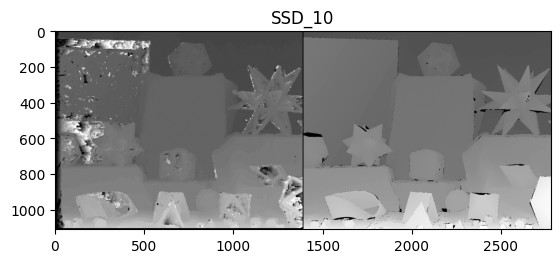

In [25]:
visualize_disparity_map(moebius_disparity, moebius_gt, 'SSD', 5)